# Lab 3 - Convolutional Neural Network for Image Classification

## Objective

* To perform image classification using convolutional neural network in Pytorch.

**Suggested reading**: 
* [Convolutional neural network - Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)
* [Feature/representation learning - Wikipedia](https://en.wikipedia.org/wiki/Feature_learning)

## Why

The fast rising of [deep learning](https://en.wikipedia.org/wiki/Deep_learning) starts on 30 September 2012, when a convolutional neural network (CNN) called [AlexNet](https://en.wikipedia.org/wiki/AlexNet) achieved a top-5 error of 15.3% in the ImageNet 2012 Challenge, more than **10.8 percentage** points lower than that of the runner up. This is considered a breakthrough and has grabbed the attention of increasing number of researchers, practioners, and the general public. Since then, deep learning has penetrated to many research and application areas. 

AlexNet contained **eight layers**. In 2015, it was outperformed by a very deep CNN with **over 100 layers** from Microsoft in the ImageNet 2015 contest.

It will be interesting to take a look at the image classification task and a CNN that can do the job well. This notebook is based on [the CIFAR10 Pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) and [CNN notebook from Lisa Zhang](https://www.cs.toronto.edu/~lczhang/360/lec/w04/convnet.html).

In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms

## 1. Image Data - CIFAR10

The [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) has ten classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

#### Loading and normalizing CIFAR10

The output of torchvision datasets (after loading) are PILImage images of range [0, 1]. 

Check out the `torchvision.transforms` API for [here](https://pytorch.org/docs/stable/torchvision/transforms.html) (search for `ToTensor` and `Normalize`).

`transforms.ToTensor()` Convert a `PIL` Image or `numpy.ndarray` (H x W x C) in the range [0, 255]  to torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].

`transforms.Normalize` normalizes a tensor image with mean and standard deviation. Given mean: ($M1,...,Mn$) and std: ($S1,..,Sn$) for $n$ channels, this transform will normalize each channel of the input `torch.*Tensor` as $input[channel] = (input[channel] - mean[channel]) / std[channel]$

`torch.utils.data.DataLoader` combines a dataset and a sampler, and provides an iterable over the given dataset. See [API here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

#### Batching

We want to use more than one images at one time. That way, we can compute the *average* loss across a **mini-batch** of $n$ *multiple* images, and take a step to optimize the *average* loss. The average loss across multiple training inputs is going to be **less "noisy"** than the loss for a single input, and is less likely to provide "bad information" because of a "bad" input. The number $n$ is called the **batch size**.

The actual batch size that we choose depends on many things. We want our batch
size to be large enough to not be too "noisy", but not so large as to make each
iteration too expensive to run.

People often choose batch sizes of the form $n=2^k$ so that it is easy to half
or double the batch size. 

####  Epoch
The way `DataLoader` works is that it randomly groups the training data into **mini-batches**
with the appropriate batch size. Each data point belongs to only one mini-batch. When there
are no more mini-batches left, the loop terminates.

In general, we may wish to train the network for longer. We may wish to use each training data
point more than once. In other words, we may wish to train a neural network for more than
**one epoch**. An **epoch** is a measure of the number of times all training data is used
once to update the parameters. 

In [2]:
batchSize=8
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#Load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)
#Load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, 
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [4]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

#### View the images

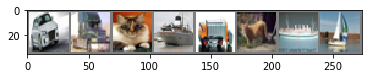

  car truck   cat  ship truck   cat  ship  ship


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #rearrange dimensions to numpy format for disply
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next() #Get one batch (4 here)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batchSize)))

## 2. Define a Convolutional Neural Network

In [6]:
import torch.nn as nn
import torch.nn.functional as F

A typical CNN architecture ![Typical CNN architecture](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)
Let us look at the CNN in detail

### Convolution layer - with a shared kernel/filter
<center>
<img src="https://www.cs.toronto.edu/~lczhang/360/lec/w04/imgs/math_kernel.png" width="100px" style="margin:0; display:inline">
<img src="https://www.cs.toronto.edu/~lczhang/360/lec/w04/imgs/math_conv.png" width="300px" style="margin:0; display:inline">
</center>

The light blue grid (middle) is the *input* that we are given, e.g., a 5 pixel by 5 pixel greyscale image. The grey grid (left) is a **convolutional kernel/filter** of size $3 \times 3$, containing the *parameters* of this neural network layer.

To compute the output, we superimpose the kernel on a region of the image. 
Let's start at the top left, in the dark blue region. The small numbers in the
bottom right corner of each grid element corresponds to the number in the kernel.
To compute the output at the corresponding location (top left), we "dot" the
pixel intensities in the square region with the kernel. That is, we perform
the computation:

In [7]:
(3 * 0 + 3 * 1 + 2 * 2) + (0 * 2 + 0 * 2 + 1 * 0) + (3 * 0 + 1 * 1 + 2 * 2)

12

The green grid (right) contains the *output* of this convolution layer.
This output is also called an **output feature map**. The terms **feature**,
and **activation** are interchangable. The output value on the top left
of the green grid is consistent with the value we obtained by hand in Python.

To compute the next activation value (say, one to the right of the previous output),
we will shfit the superimposed kernel over by one pixel:

<img src="https://www.cs.toronto.edu/~lczhang/360/lec/w04/imgs/math_conv2.png" width="300px">

The dark blue region is moved to the right by one pixel. We again dot
the pixel intensities in this region with the kernel to get another 12, and continues to get 17, ...

**Note the shrinked output**: Here, we did not use **zero padding** (at the edges) so the output of this layers is shrinked by 1 on all sides. If the kernel size is $k=2m+1$, the output will be shrinked by $m$ on all sides so the width and height will be both reduced by $2m$.

#### Convolutions with Multiple Input/Output Channels

For a colour image, the kernel will be a **3-dimensional tensor**. This kernel will move through the input features just like before, and we "dot" the pixel intensities with the kernel at each region, exactly like before. This "size of the 3rd (colour) dimension" is called the **number of input channels** or **number of input feature maps**.

We also want to detect multiple features, e.g., both horizontal edges and vertical edges. We would want to learn **many** convolutional filters on the same input. That is,
we would want to make the same computation above using different kernels, like this:

<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png" width="200px">

Each circle on the right of the image represents the output of a different kernel dotted
with the highlighted region on the right. So, the output feature is also a 3-dimensional tensor.
The size of the new dimension
is called the **number of output channels** or **number of output feature maps**.
In the picture above, there are 5 output channels.

The `conv2D` layer expects as input a tensor in the format "NCHW", meaning that the dimensions of the tensor should follow the order:

* batch size
* channel
* height
* width

Let us create a convolutional layer using `nn.Conv2d`:

In [8]:
myconv1 = nn.Conv2d(in_channels=3,  # number of input channels
                 out_channels=7, # number of output channels
                 kernel_size=5)  # size of the kernel, 

In [9]:
#Emulate a batch of 32 colour images, each of size 128x128, like this:
x = torch.randn(32, 3, 128, 128)
y = myconv1(x)
y.shape

torch.Size([32, 7, 124, 124])

The output tensor is also in the "NCHW" format. We still have 32 images, and 7 channels
(consistent with `out_channels` of `conv`), and of size 124x124. If we added the appropriate
padding to `conv`, namely `padding` = $m$ (the kernel_size: $2m+1$), then our output width and height should be consistent with the input width and height:

In [10]:
myconv2 = nn.Conv2d(in_channels=3,
                  out_channels=7,
                  kernel_size=5,
                  padding=2)

x = torch.randn(32, 3, 128, 128)
y = myconv2(x)
y.shape

torch.Size([32, 7, 128, 128])

#### The parameters of `Conv2d`

In [11]:
conv_params = list(myconv2.parameters())
print("len(conv_params):", len(conv_params))
print("Filters:", conv_params[0].shape)  #7 filters, each of size 3 x 5 x 5
print("Biases:", conv_params[1].shape)

len(conv_params): 2
Filters: torch.Size([7, 3, 5, 5])
Biases: torch.Size([7])


### Pooling Layers - Subsampling

A pooling layer can be created like this: 
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png" width="300px">

In [12]:
mypool = nn.MaxPool2d(kernel_size=2, stride=2)
y = myconv2(x)
z = mypool(y)
z.shape

torch.Size([32, 7, 64, 64])

Usually, the kernel size and the stride length will be equal so each pixel is pooled only once. 
The pooling layer has **no trainable parameters**:

In [13]:
list(mypool.parameters())

[]

Here is the CNN defined in the Pytorch tutorial.

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

This network has **two** convolutional layers: `conv1` and `conv2`.

- The first convolutional layer `conv1` requires an input with 3 channels,
  outputs **6 channels**, and has a kernel size of `5x5`. We are not adding any zero-padding.
- The second convolutional layer `conv2` requires an input with **6 channels** (note this **MUST match the output channel number of the previous layer**),  outputs 16 channels, and has a kernel size of (again) `5x5`. We are not adding any zero-padding.

In the `forward` function we see that the convolution operations are always 
followed by the usual ReLU activation function, and a pooling operation.
The pooling operation used is max pooling, so each pooling operation
**reduces the width and height of the neurons in the layer by half**.

Because we are not adding any zero padding, we end up with `16 * 5 * 5` hidden units
after the second convolutional layer (`16` matches the output channel number of `conv2`, `5 * 5` is based on the input dimension `32x32`, see below). These units are then passed to two fully-connected
layers, with the usual ReLU activation in between.

Notice that the number of channels **grew** in later convolutional layers! However,
the number of hidden units in each layer is still reduced because of the convolution and pooling operation:

* Initial Image Size: $3 \times 32 \times 32 $
* After `conv1`: $6 \times 28 \times 28$ ($32 \times 32$ is reduced by `2` on each side)
* After Pooling: $6 \times 14 \times 14 $ (image size halved)
* After `conv2`: $16 \times 10 \times 10$ ($14 \times 14$ is reduced by `2` on each side)
* After Pooling: $16 \times 5 \times 5 $ (halved)
* After `fc1`: $120$
* After `fc2`: $84$
* After `fc3`: $10$ (**= number of classes**)

This pattern of **doubling the number of channels with every pooling / strided convolution**
is common in modern convolutional architectures. It is used to avoid loss of too much information within
a single reduction in resolution.


## 3. Optimisation, Training and Testing

### Choose a criterion (cross-entropy loss) and an optimizer (SGD with momentum)

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.

In [16]:
max_epochs=2
for epoch in range(max_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.184
[1,  4000] loss: 1.827
[1,  6000] loss: 1.636
[2,  2000] loss: 1.483
[2,  4000] loss: 1.434
[2,  6000] loss: 1.373
Finished Training


### Save our trained model:

In [17]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### Test the network on the test data

We will test the trained network by predicting the class label that the neural network outputs, and checking it against the ground-truth. Okay, first step. Let us display an image from the test set to get familiar.

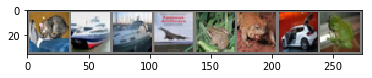

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog


In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batchSize)))

Next, let's load back in our saved model (note: saving and re-loading wasn't necessary here, we only did it for illustration):



In [19]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [20]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [21]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batchSize)))

Predicted:    cat  ship  ship plane  frog  frog   car  frog


How accurate do you get? Note that the results are *random* because the batches are randomly formed (**Question**: how to fix them?). Let us look at how the network performs on the whole dataset.

In [22]:
correct = 0
total = 0
with torch.no_grad():  #testing phase, no need to compute the gradients to save time
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 68 %
Accuracy of  bird : 30 %
Accuracy of   cat :  5 %
Accuracy of  deer : 36 %
Accuracy of   dog : 46 %
Accuracy of  frog : 79 %
Accuracy of horse : 69 %
Accuracy of  ship : 69 %
Accuracy of truck : 56 %


## 4. Exercises


* Train the network for more passes (epochs) and/or other training settings (e.g., other patch sizes) to study whether there will be any performance improvement.
* Practice change the CNN architecture (pay attention to the size matching between different layers).
* Try on GPU if you have one by following the end of the [the CIFAR10 Pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py).
* Try out the AlexNet `torchvision.models.alexnet` and other architectures from `torchvision.models` for image classification
* Try out other pytorch computer vision datasets `torchvision.datasets` for image classification. 


# References

* [CS231n: Convolutional Neural Networks for Visual Recognition from Stanford](http://cs231n.github.io/)